# Evaluation of Graph Neural Network segment classifier

In [ ]:
%pwd

In [2]:
# System imports
import os
import sys

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      plot_train_history, compute_metrics, plot_metrics,
                      draw_sample_xy)

In [3]:
# Config path
config_file = '../configs/mpnn.yaml'

In [4]:
!cat $config_file

output_dir: ${SCRATCH}/heptrkx/results/mpnn_002

trainer:
    name: gnn_sparse

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_high_000
    n_train: 49152 #57344
    n_valid: 4096
    real_weight: 5 #6.25  # 0.5 / 0.08
    batch_size: 4
    n_workers: 4

model:
    name: mpnn
    input_dim: 3
    hidden_node_dim: 64
    hidden_edge_dim: 64
    n_graph_iters: 8
    layer_norm: true
    loss_func: binary_cross_entropy_with_logits

optimizer:
    name: SGD
    momentum: 0.9
    learning_rate: 0.01
    lr_scaling: sqrt
    lr_warmup_epochs: 5
    lr_decay_schedule:
        - {start_epoch: 16, end_epoch: 32, factor: 0.1}
        - {start_epoch: 32, end_epoch: 64, factor: 0.01}

training:
    n_epochs: 64


In [5]:
config = load_config(config_file)
summaries = load_summaries(config)

In [6]:
summaries

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.0100,0.467629,0,3606.790947,0.318004,0.819629,109.203412
1,0.0100,0.402328,1,2624.231825,0.546204,0.721451,104.981948
2,0.0100,0.512857,2,2645.444784,0.503409,0.780491,111.780221
3,0.0100,0.306003,3,2677.982403,0.269672,0.851281,111.260923
4,0.0100,0.261329,4,2607.369807,0.235777,0.877298,120.223003
5,0.0100,0.245517,5,2556.434486,0.217399,0.890347,104.427193
6,0.0100,0.236094,6,2574.626320,0.284981,0.849460,104.521105
7,0.0100,0.230457,7,2557.100412,0.200666,0.901557,122.281710
8,0.0100,0.226404,8,2543.328393,0.200491,0.899975,104.679573
9,0.0100,0.221874,9,2493.307322,0.208874,0.895689,104.597958


## Plot the Training loss and accuracy

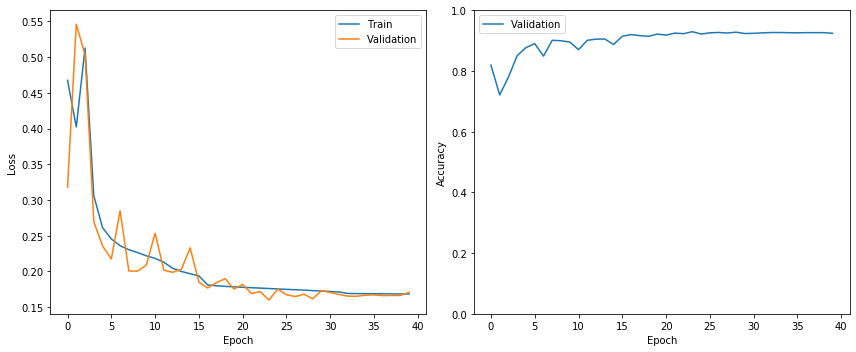

In [7]:
plot_train_history(summaries)

## Load the trained model

In [8]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
23,0.001,0.176143,23,2496.768058,0.160034,0.929787,116.378197


In [9]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=134, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=131, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bia

## Load the test data set and evaluate the model

In [10]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [11]:
%%time
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 30s, sys: 4.05 s, total: 1min 34s
Wall time: 24 s


In [12]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9293
Precision: 0.5048
Recall:    0.9081


In [13]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9611
Precision: 0.7172
Recall:    0.7593


In [14]:
threshold = 0.9
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.9
Accuracy:  0.9626
Precision: 0.8324
Recall:    0.6018


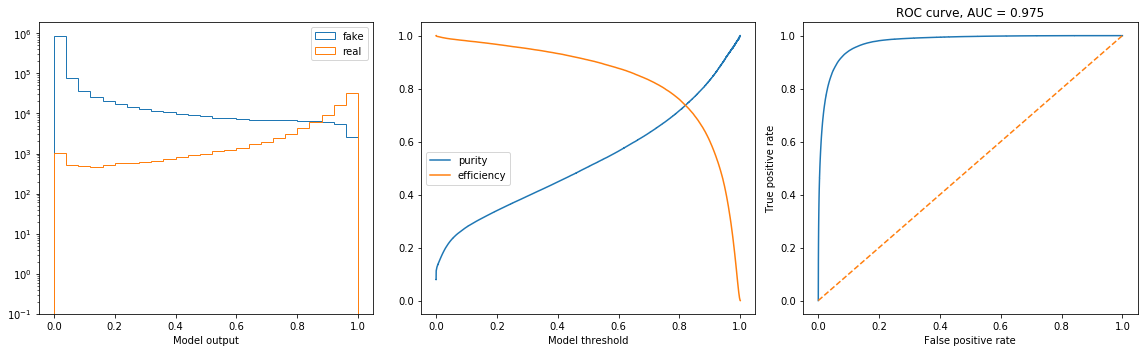

In [15]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [16]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

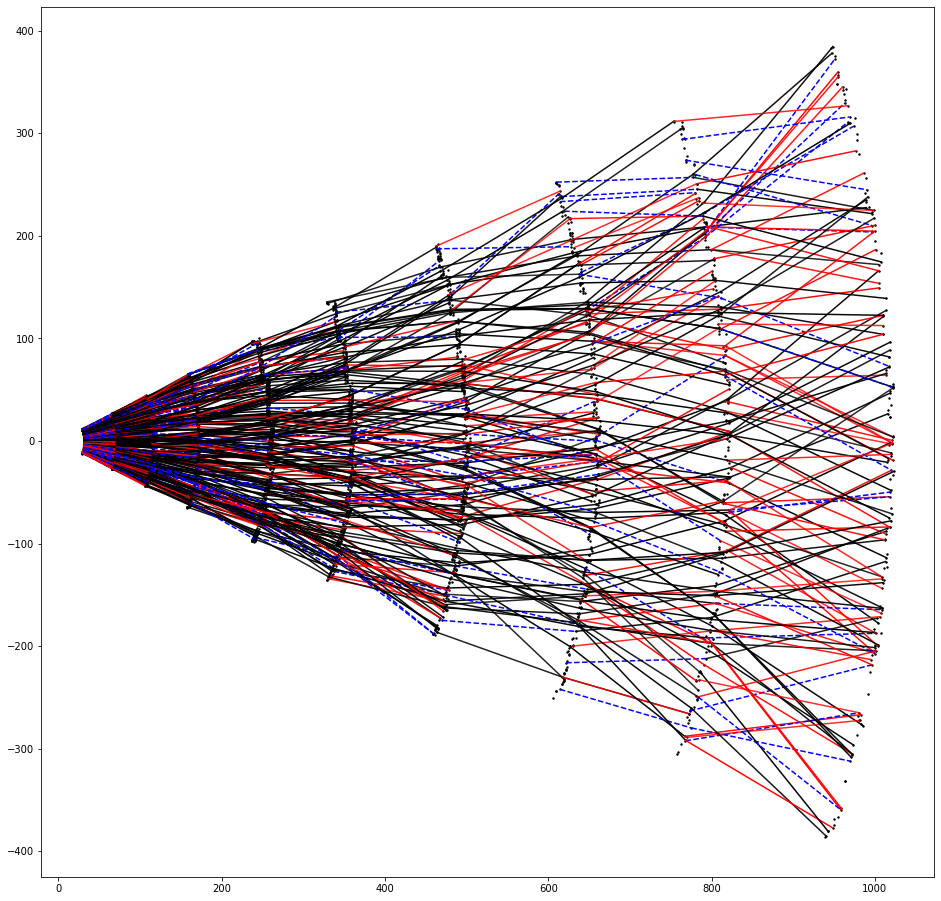

In [18]:
draw_sample_xy(x, e, o, y, cut=0.8);